## 2 Pre-Processing of Data and EDA

This notebook aims to document both the **pre-processing** steps taken to sift through and clean data, as well as the **exploratory data analysis** (EDA) on the data itself.

For the EDA portion, we will looking mainly at n-grams and text length to gain some insights into the strength and efficacy of the data obtained, and what we believe to be able to use such data for.

In [1]:
# Base Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For Web Scraping
from bs4 import BeautifulSoup
import requests

# For Pre-Processing/Word Cleaning
import re, nltk, string
import demoji
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# For Modelling
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay 
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

# Miscellaneous
import time
from tqdm.notebook import tqdm
import mlflow

In [2]:
# Reloading from saved checkpoint so that we don't have to rerun the scraping algorithm every time
data_df = pd.read_csv('Datasets/reddit_data.csv')


#### 2.0.1 Setting Up Stopword Definitions

In [3]:
# Setting up stopwords set
Stopwords = set(stopwords.words('english'))
Stopwords.update(['a','the']) # to include more words in the stopwords set


#### 2.0.2 Functions for Pre-Processing

In [4]:
# Remove unnecessary null fields, which signifies empty selftext
def rem_emp_selftext(text):
    text = text.replace('[removed]','').replace('nan','').replace('[deleted]','')
    return text


In [5]:
def rem_emojis(text):
    for i in demoji.findall(text).keys():
        text.replace(i,'')
    return text

In [6]:
# Remove urls
def rem_url(text):
    url_key = re.compile(r"(https?:\/\/)(\s)*(www\.)?(\s)*((\w|\s)+\.)*([\w\-\s]+\/)*([\w\-]+)((\?)?[\w\s]*=\s*[\w\%&]*)*")
    text = url_key.sub('',text)
    return text


In [7]:
# Remove special characters
def rem_special_char(obj):
    punc_rem = re.compile(r"[^\w\s]") # all terms that are not(^) words (\w) or spaces (\s)
    
    if type(obj) == list: # Treatment if object is a list
        obj = [punc_rem.sub('',i) for i in obj]
        return obj
    
    elif type(obj) == str: # Treatment if object is a string
        obj = punc_rem.sub('',obj)
        return obj


In [8]:
# Stopwords Removal
def stopwords_removal(tokens, stopwords_used = Stopwords):
    tokens = [word for word in tokens if word not in stopwords_used]
    return tokens


In [9]:
# Lemmatiser
def lemmatise(tokens):
    lemmatiser = WordNetLemmatizer()
    tokens = [lemmatiser.lemmatize(i) for i in tokens]
    return tokens


In [10]:
# Stemmer 
def stemmise(tokens):
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(i) for i in tokens]
    return tokens


In [11]:
# Recombine to make count-vectorisation easier, toggleable 
def concat_list(tokens):
    text_tmp = ''
    for i in range(len(tokens)):
        if i != len(tokens) - 1: text_tmp += tokens[i] + ' '
        else: text_tmp += tokens[i]
    return text_tmp

In [12]:
# Combine all above functions
def clean_data(data_df, process, concat_tokens = True, stopwords_used = Stopwords):
    
    start_time = time.time()
    # Define cleaned dataset to update
    data_df_cleaned = data_df[['title','selftext','subreddit']][:]

    #---------------------------------------------------------------
    # Perform cleaning functions
    # 1.  Remove empty fields in selftext
    # 2.  Combine title and selftext into single string vector
    # 3.  Lowercase text
    # 4.  Remove Emojis
    # 5.  Remove urls
    # 6.  Tokenise text by words
    # 7.  Remove stopwords
    # 8.  Remove Special Characters  
    # 9.  Remove blanks
    # 10. lemmatise/stem tokens (choose using 'process' variable)
    #---------------------------------------------------------------
    
    for i in tqdm(data_df_cleaned.index):

        data_df_cleaned.loc[i,'selftext'] = rem_emp_selftext(str(data_df_cleaned.loc[i,'selftext']))
        data_df_cleaned.loc[i,'title'] += data_df_cleaned.loc[i,'selftext'] 
        data_df_cleaned.loc[i,'title'] = data_df_cleaned.loc[i,'title'].lower() 
        data_df_cleaned.loc[i,'title'] = rem_emojis(data_df_cleaned.loc[i,'title']) 
        data_df_cleaned.loc[i,'title'] = rem_url(data_df_cleaned.loc[i,'title']) 
        
        data_df_cleaned.loc[i,'title'] = word_tokenize(data_df_cleaned.loc[i,'title'])
        data_df_cleaned.loc[i,'title'] = stopwords_removal(data_df_cleaned.loc[i,'title'], stopwords_used) 
        data_df_cleaned.loc[i,'title'] = rem_special_char(data_df_cleaned.loc[i,'title']) 
        data_df_cleaned.loc[i,'title'] = [j for j in data_df_cleaned.loc[i,'title'] if j != ''] 

        if process == 'lemmatise': 
            data_df_cleaned.loc[i,'title'] = lemmatise(data_df_cleaned.loc[i,'title']) # Lemmatise tokens
        elif process == 'stem':
            data_df_cleaned.loc[i,'title'] = stemmise(data_df_cleaned.loc[i,'title']) # Stem tokens
    
        #Recombine list into text string, unless otherwise specified
        if concat_tokens == True: 
            data_df_cleaned.loc[i,'title'] = concat_list(data_df_cleaned.loc[i,'title']) 
    
    # Rename to 'text', and remove selftext column
    data_df_cleaned.rename({'title':'text'}, axis = 1, inplace = True)
    data_df_cleaned.drop(columns = 'selftext', inplace = True)
    
    time_curr = time.time()
    minutes = int(round(((time_curr - start_time)/60) % 60,0))
    seconds = int(round((time_curr - start_time) % 60,0))
    
    print(f'Finished, elapsed time: {minutes}m {seconds}s')
    return data_df_cleaned


#### 2.0.3 Functions for EDA

In [16]:
# Function to generate top 20 words of dataset for science and philosophy
def gen_top20words(df_arr, subred1 = 'science', subred2 = 'philosophy', w_pad = 7.5):
    
    # subred1 top 20 words
    globals()['tva_'+subred1] = df_arr[df_arr['subred_key'] == subred1]
    globals()['tva_'+subred1+'_top20'] = globals()['tva_'+subred1].iloc[:,1:].sum().sort_values(
        ascending = False).head(20)
    
    # subred1 top 20 words
    globals()['tva_'+subred2] = df_arr[df_arr['subred_key'] == subred2]
    globals()['tva_'+subred2+'_top20'] = globals()['tva_'+subred2].iloc[:,1:].sum().sort_values(
        ascending = False).head(20)
    
    # Plot graph
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14,7))
    fig.suptitle('Top 20 Words for Each Subreddit', fontsize = 20)
    fig.tight_layout(pad=2.0, w_pad = w_pad)

    ax1.barh(y = globals()['tva_'+subred1+'_top20'].index, width = globals()['tva_'+subred1+'_top20'].values)
    ax2.barh(y = globals()['tva_'+subred2+'_top20'].index, width = globals()['tva_'+subred2+'_top20'].values)

    ax1.set_title('Science')
    ax2.set_title('Philosophy')

    ax1.invert_yaxis()
    ax2.invert_yaxis()
    ax1.set_xlabel('frequency')
    ax2.set_xlabel('frequency');
    

In [21]:
# For pulling out a snapshot of the texts of the selected keyword vector
def df_vect_insight(df, subred, keywords):
    indices = []
    
    if type(keywords) == list:
        for keyword in keywords:
            [indices.append(i) for i in globals()['tva_'+subred][globals()['tva_'+subred][keyword] == 1].index]
        
        indices = np.unique(indices)
        
    elif type(keywords) == str:
        indices = globals()['tva_'+subred][globals()['tva_'+subred][keywords] == 1].index
    
    return df.loc[indices]


### 2.1 Pre-Processing and Data Cleaning

**Pre-Processing Cleaning Steps Taken:**
1.  Remove empty fields in selftext
2.  Combine title and selftext into single string vector
3.  Lowercase text
4.  Remove Emojis
5.  Remove urls
6.  Tokenise text by words
7.  Remove stopwords
8.  Remove Special Characters  
9.  Remove blanks
10. lemmatise tokens (*Due to time constraints, stemmatised tokens will not be explored*)

In [13]:
df_cleaned = clean_data(data_df, 'lemmatise')

  0%|          | 0/50000 [00:00<?, ?it/s]

Finished, elapsed time: 1m 13s


In [14]:
# Count Vectorisation for EDA
cvec = CountVectorizer()
X_temp_vec = cvec.fit_transform(df_cleaned['text'])


In [15]:
# Creating vector array of words for data exploration
text_vec_array = pd.DataFrame(X_temp_vec.toarray(), columns = cvec.get_feature_names_out())
text_vec_array.insert(0,'subred_key',df_cleaned['subreddit'])


#### 2.1.1 Most Used Words

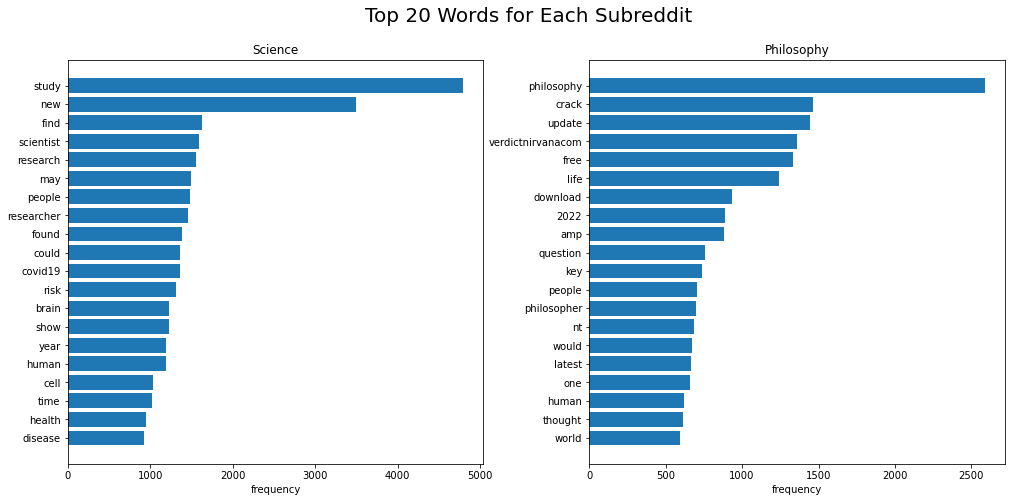

In [17]:
#### Plotting both histograms
gen_top20words(text_vec_array)

**Observations:**  
*Science:*
1. The science posts seem to have decent identifiers, based on the top 20 words.
2. Considerations for 'noise' in science: 'covid19'.

*Philosophy:*
1. Seems to be quite a number of 'spam' entries that need to be investigated, namely 'crack', 'update', 'verdictnirvanacom', 'download'.
2. Lower frequency in highest used words suggest a more diverse pool of vocabulary in the philosophy subreddit than the science one.

In [22]:
# Checking out 'covid19' vector in science
df_vect_insight(df_cleaned, 'science', 'covid19').head()

,text,subreddit
24799,study huanan seafood wholesale market wuhan ch...,science
24932,automated text messaging service significantly...,science
24938,eating disorder hospitalization doubled covid1...,science
24947,prominent virologist warns covid19 pill could ...,science
25007,people daily activity affected mood covid19 pa...,science


In [23]:
# Checking out 'crack' vector in philosophy
df_vect_insight(df_cleaned, 'philosophy', 'crack')
# The 'crack' vector seems to correspond to noise about CD-keys for softwares, 
# and not actually talking about anything in r/philosophy

,text,subreddit
1462,net balancer 10242570 crack latest download,philosophy
1557,snagit 202120 build 7921 crack latest download,philosophy
2077,blumentals web builder 2021 1630231 crack latest,philosophy
2176,advanced installer architect 1780 crack latest...,philosophy
2181,vsco cam v195 vsco x crack latest version,philosophy
...,...,...
25152,fl studio 20922963 crack plus reg key download...,philosophy
25155,omnisphere 3 crack keygen serial key free down...,philosophy
25157,overloud thu full crack 349 latest version dow...,philosophy
25159,twinmotion crack 20222 plus license code 100 w...,philosophy


In [24]:
# Checking out 'crack' vector in philosophy
df_vect_insight(df_cleaned, 'philosophy', 'download')
# Similar to crack, downloads seem to be mostly noise

,text,subreddit
1462,net balancer 10242570 crack latest download,philosophy
1557,snagit 202120 build 7921 crack latest download,philosophy
2355,davinci resolve studio 1700b0009 crack latest ...,philosophy
2715,auslogics boostspeed crack 12004 latest download,philosophy
2783,idm ultra edit 280046 crack latest download,philosophy
...,...,...
25149,audio ease altiverb crack 7 xl v748 free downl...,philosophy
25152,fl studio 20922963 crack plus reg key download...,philosophy
25155,omnisphere 3 crack keygen serial key free down...,philosophy
25157,overloud thu full crack 349 latest version dow...,philosophy


In [25]:
# Checking out 'update' vector in philosophy
df_cleaned.loc[df_vect_insight(df_cleaned,'philosophy','verdictnirvanacom').index]
# Similar to crack, update seem to be mostly noise, especially 131 rows of data that only have 'update' as text.
# Further investigation shows that these rows correspond to some update post from VerdictNirvana.Com, and can
# be considered noise, and can be removed.

,text,subreddit
76,update verdictnirvanacom,philosophy
875,update verdictnirvanacom,philosophy
898,update verdictnirvanacom,philosophy
1653,update verdictnirvanacom,philosophy
1654,update verdictnirvanacom,philosophy
...,...,...
25083,update verdictnirvanacom,philosophy
25095,update verdictnirvanacom,philosophy
25180,update verdictnirvanacom,philosophy
25187,update verdictnirvanacom,philosophy


**Checkpoint:**
1. For science, the covid19 tag does not seem to be noise.
2. In contrast, the posts in philosophy with 'crack', 'download', and 'verdictnirvanacom' are most likely related to noise, and should be removed from the set.

##### 2.1.1.1 Removing Noise from philosophy set

In [26]:
# Set of words to drop
keywords = ['crack','download','verdictnirvanacom']

# Run cleaning function again with new stopwords set
df_cleaned = df_cleaned.drop(index = df_vect_insight(df_cleaned,'philosophy',keywords).index, errors = 'ignore')

In [27]:
# Checking number of data points again
df_cleaned.groupby('subreddit').count()

,text
subreddit,
philosophy,22126
science,25000


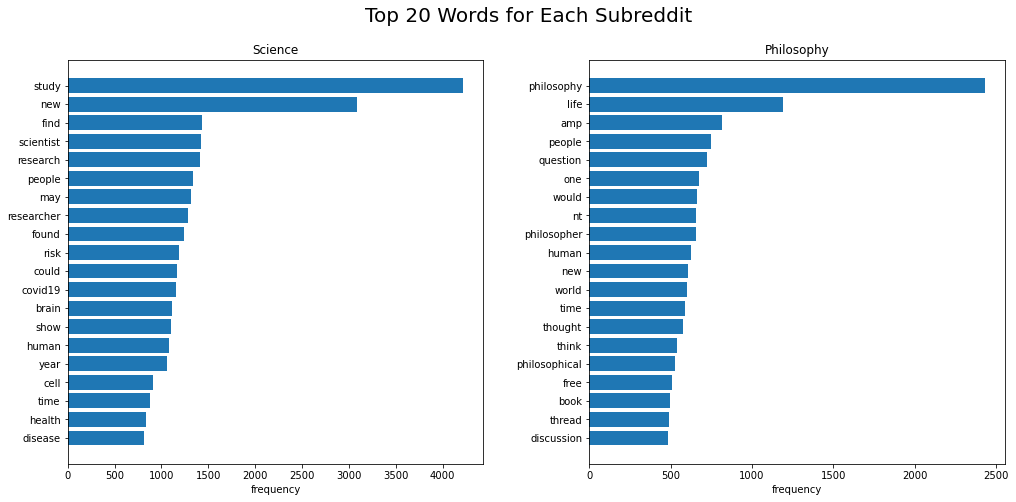

In [28]:
# Updating Grid Vector Array and plotting graph again
cvec = CountVectorizer()
X_temp_vec = cvec.fit_transform(df_cleaned['text'])

text_vec_array = pd.DataFrame(X_temp_vec.toarray(), columns = cvec.get_feature_names_out())
text_vec_array.insert(0,'subred_key',df_cleaned['subreddit'])

gen_top20words(text_vec_array)

#### 2.1.2 Verdict
At this point, the 'noise' text vectors specified in the previous section have been removed. The instances of 'crack' and 'download', which were identified to be linked to recurring ad or noise posts, have been removed, and the 'update' posts linked to instances of 'verdictnirvana.com' have been removed as well. We can now continue to look at our EDA for this dataset.

### 2.2 N-grams
#### Bigrams

(47126, 7151)


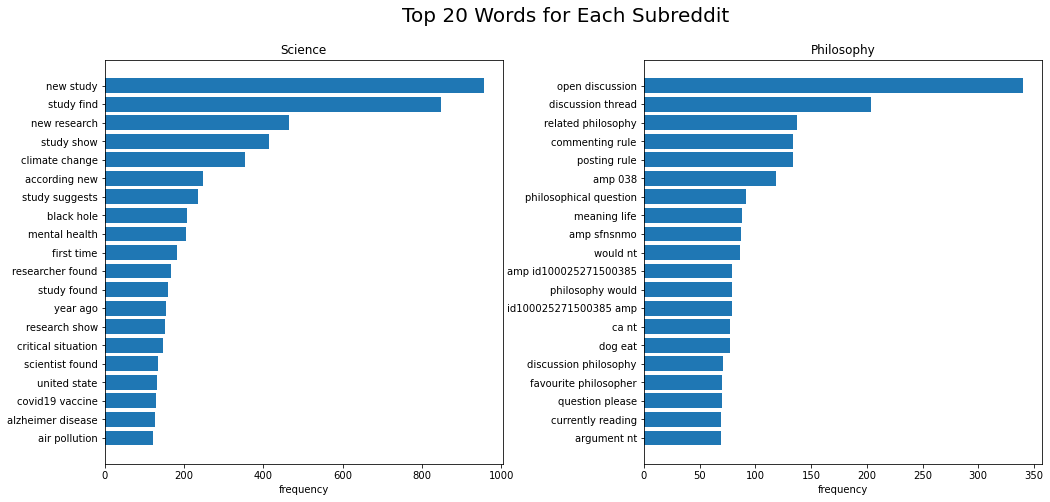

In [29]:
# Creating Countvectorizer set for bigrams
cvec2 = CountVectorizer(ngram_range = (2,2), min_df = 0.0001)
X_temp_vec2 = cvec2.fit_transform(df_cleaned['text'])

text_vec2_array = pd.DataFrame(X_temp_vec2.toarray(), columns = cvec2.get_feature_names_out())
text_vec2_array.insert(0,'subred_key',df_cleaned['subreddit'])

# Plotting the top 20 bigrams for each subreddit
gen_top20words(text_vec2_array, w_pad = 11)
print(text_vec2_array.shape)

#### Trigrams

(47126, 1771)


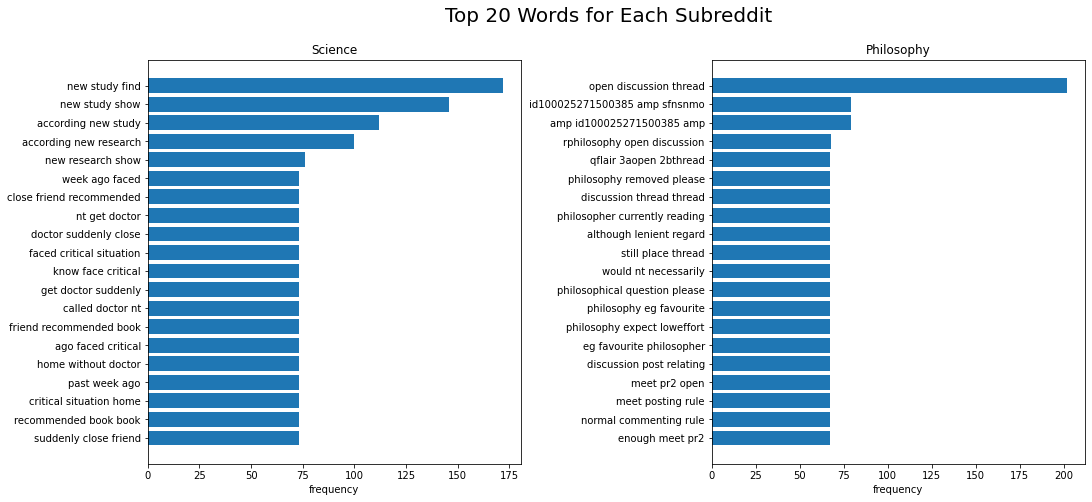

In [30]:
# Creating Countvectorizer set for trigrams
cvec3 = CountVectorizer(ngram_range = (3,3), min_df = 0.0001)
X_temp_vec3 = cvec3.fit_transform(df_cleaned['text'])

text_vec3_array = pd.DataFrame(X_temp_vec3.toarray(), columns = cvec3.get_feature_names_out())
text_vec3_array.insert(0,'subred_key',df_cleaned['subreddit'])

# Plotting the top 20 bigrams for each subreddit
gen_top20words(text_vec3_array, w_pad = 16)
print(text_vec3_array.shape)

#### N-gram EDA Summary:  
From both the bigram and trigram analysis, we notice a few notable points of observation. 

The science bi and trigrams are consistent with the unigrams; they are largely reflective of expected scientific speech rhetoric, and give us confidence in the text as an objective vector for subreddit prediction.  

In contrast, the r/philosophy n-grams, much like the unigrams, reflects alot of clutter and spam, some of which was not removed in this EDA's pre-processing stage. This is a consideration for future improvement of the model; that is, to look into cleaning out the remaining spam posts from the philosophy subreddit, and see whether cleaner datasets would allow us better, more accurate predictions.

### 2.3 Text Length

/var/folders/lq/srsmyfy13n76jc0b1w69wgyc0000gn/T/ipykernel_23586/244364458.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for i in df_len.index: df_len.loc[i,'textlen'] = len(df_len.loc[i,'title'])


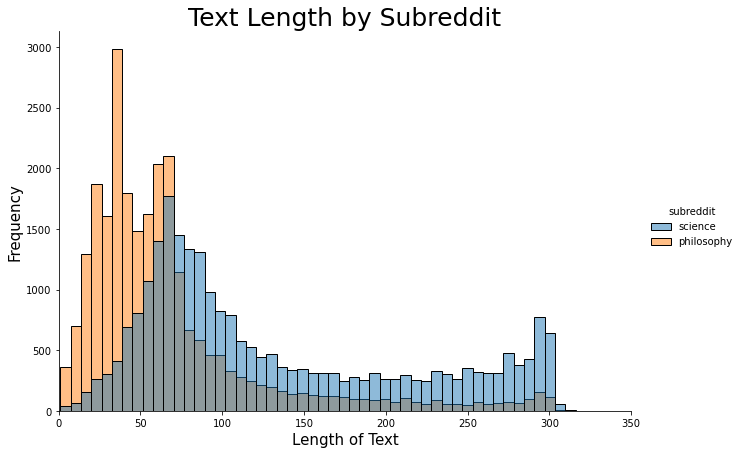

In [32]:
df_len = data_df[:]
for i in df_len.index: df_len.loc[i,'textlen'] = len(df_len.loc[i,'title'])
sns.displot(data = df_len['textlen'],
            x = df_len['textlen'],
            hue = df_len['subreddit'],
            height = 6,
            aspect = 1.5,
            bins = 50
            )
plt.title('Text Length by Subreddit', fontsize = 25)
plt.ylabel('Frequency', fontsize = 15)
plt.xlabel('Length of Text', fontsize = 15)
plt.xlim(0,350);

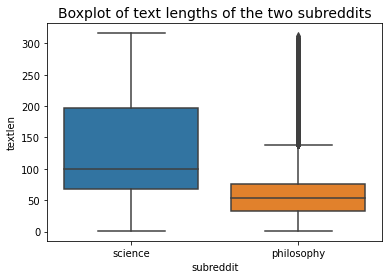

In [48]:
sns.boxplot(x= df_len['subreddit'], y = df_len['textlen'], fliersize = 5, whis = 1.5)
plt.title('Boxplot of text lengths of the two subreddits', fontsize = 14);

**Observations**  
In general, we can see that the text length for posts in the science subreddit are longer than those in the philosophy subreddit. Both distributions are quite left-skewed, with the median closer to the left than the right. This is especially true for r/philosophy, where the the 25th to 75th percentiles are scrunched close together around 50 words per submission.

The spread of text lengths for submissions varies alot more for r/science posts than r/philosophy. This gives us some confidence that text-based vectors would be good descriptors for predicting which subreddit the information may come from (*median ~100 words for science, and ~50 for philosophy*).

### 2.4 Export to .csv

In [31]:
# Export unvectorised dataframe for use with pipeline models that can integrate Countvectorisation
df_cleaned.to_csv('Datasets/df_cleaned_unvect.csv', index = False)


In [32]:
# Caveat: After the data cleaning, it seems that some 'text' fields became blank, 
# and only registered as blank after the export.

df_import = pd.read_csv('Datasets/df_cleaned_unvect.csv')
df_import.isnull().sum()

text         839
subreddit      0
dtype: int64

In [33]:
# This last bit of code is to drop the now empty posts, and re-export the .csv:
df_import = df_import.drop(index = df_import[df_import['text'].isnull()].index)
df_import.to_csv('Datasets/df_cleaned_unvect.csv', index = False)